# PyTorch hardware benchmark analysis

Single node throughput comparisons between different hardware options at NERSC.

In [6]:
import os
import re
import glob

import pandas as pd
import matplotlib.pyplot as plt

In [7]:
%matplotlib inline

In [8]:
plt.rcParams.update({'font.size': 14})

## Load the results

In [9]:
version = 'v1.2.0'
pattern = '/global/cscratch1/sd/sfarrell/pytorch-benchmarks/*-%s-n1/results.txt' % version

In [10]:
results_files = glob.glob(pattern)

results_files

['/global/cscratch1/sd/sfarrell/pytorch-benchmarks/gpu-v1.2.0-n1/results.txt',
 '/global/cscratch1/sd/sfarrell/pytorch-benchmarks/hsw-v1.2.0-n1/results.txt',
 '/global/cscratch1/sd/sfarrell/pytorch-benchmarks/knl-v1.2.0-n1/results.txt']

In [11]:
results = [pd.read_csv(f, delim_whitespace=True) for f in results_files]
results = pd.concat(results, ignore_index=True)

results

,train_rate,inference_rate,ranks,hardware,version,model
0,182.525779,635.350850,1,gpu,v1.2.0,inceptionV3
1,5061.086456,14818.019022,1,gpu,v1.2.0,lstm
2,460.914036,2613.454798,1,gpu,v1.2.0,alexnet
3,247.850647,894.464710,1,gpu,v1.2.0,resnet50
4,196.265852,1043.327016,1,gpu,v1.2.0,vgg11
5,837.224941,5208.378940,1,gpu,v1.2.0,cnn3d
6,13.557418,47.904272,1,hsw,v1.2.0,inceptionV3
7,362.557148,796.934826,1,hsw,v1.2.0,lstm
8,203.419221,714.774127,1,hsw,v1.2.0,alexnet
9,14.629206,50.253714,1,hsw,v1.2.0,resnet50


## Tables

In [12]:
# Training rate per hardware
results.groupby('model').apply(lambda g: pd.Series(data=g.train_rate.values, index=g.hardware))

hardware,gpu,hsw,knl
model,,,
alexnet,460.914036,203.419221,152.366994
cnn3d,837.224941,191.446156,84.124433
inceptionV3,182.525779,13.557418,6.673162
lstm,5061.086456,362.557148,143.620939
resnet50,247.850647,14.629206,6.683705
vgg11,196.265852,20.162038,12.770113


In [13]:
# Evaluation rate per hardware
results.groupby('model').apply(lambda g: pd.Series(data=g.inference_rate.values, index=g.hardware))

hardware,gpu,hsw,knl
model,,,
alexnet,2613.454798,714.774127,953.115629
cnn3d,5208.378940,406.663932,171.109153
inceptionV3,635.350850,47.904272,25.073184
lstm,14818.019022,796.934826,433.675437
resnet50,894.464710,50.253714,14.788528
vgg11,1043.327016,62.550474,36.581326


## Training throughput comparisons

In [15]:
models = ['alexnet', 'vgg11', 'inceptionV3', 'resnet50', 'cnn3d', 'lstm']
results_by_model = results.groupby('model')

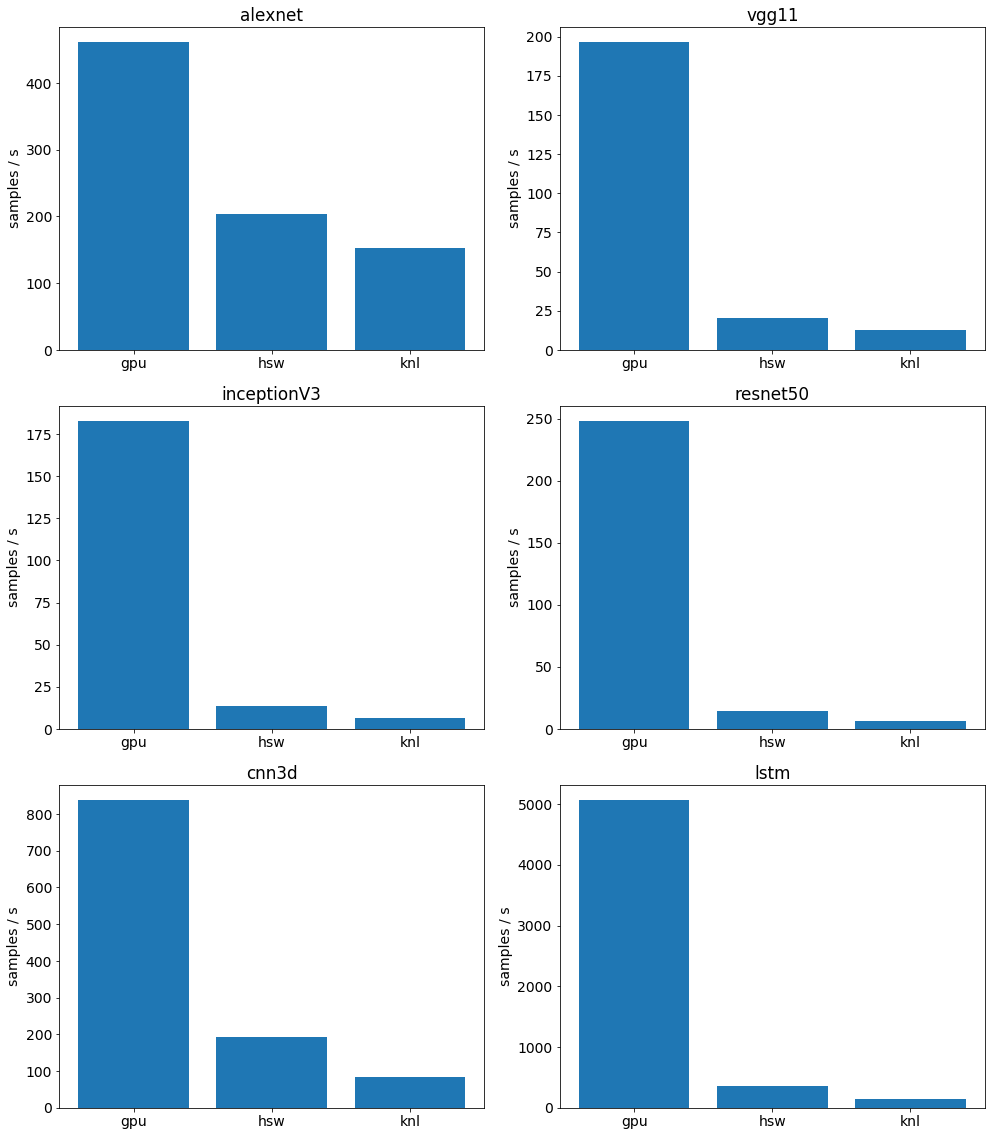

In [16]:
fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(14, 16))
axs = axs.flatten()

for i, model in enumerate(models):
    ax = axs[i]
    model_results = results_by_model.get_group(model)
    ax.bar(model_results.hardware, model_results.train_rate)
    ax.set_title(model)
    ax.set_ylabel('samples / s')

plt.tight_layout()